# Spotify API and Lyrics Analysis

In [1]:
!pip install spotipy pandas matplotlib lyricsgenius nltk wordcloud
!pip install textblob

In [5]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import matplotlib.pyplot as plt
from lyricsgenius import Genius
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
import string
import re

In [9]:
# Authentication
client_credentials_manager = SpotifyClientCredentials(client_id='dac2a169157447f6be0997311fc87b8b', client_secret='6f3fc22ffbd24fe19b709bf0c9a82af1')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
genius = Genius('your_genius_access_token')
genius.timeout = 15  # Increase timeout to 15 seconds

In [11]:
## Task 1: Data Collection

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from lyricsgenius import Genius
import re
import time

# Authentication
client_id = 'dac2a169157447f6be0997311fc87b8b'
client_secret = '6f3fc22ffbd24fe19b709bf0c9a82af1'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
genius = Genius('your_genius_access_token')

def extract_playlist_id(input_string):
    # Try to match playlist ID patterns
    patterns = [
        r'spotify:playlist:([a-zA-Z0-9]+)',  # Spotify URI
        r'https://open.spotify.com/playlist/([a-zA-Z0-9]+)',  # Spotify URL
        r'^([a-zA-Z0-9]+)$'  # Direct playlist ID
    ]
    
    for pattern in patterns:
        match = re.search(pattern, input_string)
        if match:
            return match.group(1)
    
    return None

# Use the playlist URL directly without user input
playlist_input = "https://open.spotify.com/playlist/5ABHKGoOzxkaa28ttQV9sE?si=1b0698e95a554684"
playlist_id = extract_playlist_id(playlist_input)

if playlist_id:
    print(f"Using playlist ID: {playlist_id}")
else:
    print("Invalid playlist URL. Please check the URL and try again.")
    # You might want to exit the script here if the URL is invalid

def get_playlist_tracks(playlist_id):
    tracks = []
    results = sp.playlist_items(playlist_id)
    tracks.extend(results['items'])
    
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    
    return tracks

try:
    playlist_tracks = get_playlist_tracks(playlist_id)
    print(f"Successfully fetched {len(playlist_tracks)} tracks from the playlist.")
except spotipy.exceptions.SpotifyException as e:
    print(f"Error fetching playlist: {e}")
    print("Please check your Spotify API credentials and ensure you have the necessary permissions.")

def extract_track_info_and_lyrics(tracks):
    data = []
    for track in tracks:
        track_info = track['track']
        artist_name = track_info['artists'][0]['name']
        track_name = track_info['name']
        
        # Fetch lyrics with error handling and rate limiting
        try:
            song = genius.search_song(track_name, artist_name)
            lyrics = song.lyrics if song else "Lyrics not found"
        except Exception as e:
            print(f"Error fetching lyrics for {track_name} by {artist_name}: {e}")
            lyrics = "Error fetching lyrics"
        
        data.append({
            'artist': artist_name,
            'track': track_name,
            'popularity': track_info['popularity'],
            'lyrics': lyrics
        })
        
        time.sleep(1)  # Wait 1 second between requests to avoid rate limiting
    
    return pd.DataFrame(data)

df = extract_track_info_and_lyrics(playlist_tracks)

# Display the first few rows of the dataframe
print(df.head())

# Display basic information about the dataframe
print(df.info())

# Display summary statistics of the dataframe
print(df.describe())

Using playlist ID: 5ABHKGoOzxkaa28ttQV9sE
Successfully fetched 100 tracks from the playlist.
Searching for "Blinding Lights" by The Weeknd...
Done.
Searching for "Shape of You" by Ed Sheeran...
Done.
Searching for "Someone You Loved" by Lewis Capaldi...
Done.
Searching for "As It Was" by Harry Styles...
Done.
Searching for "Sunflower - Spider-Man: Into the Spider-Verse" by Post Malone...
Done.
Searching for "Starboy" by The Weeknd...
Done.
Searching for "One Dance" by Drake...
Done.
Searching for "STAY (with Justin Bieber)" by The Kid LAROI...
Done.
Searching for "Dance Monkey" by Tones And I...
Done.
Searching for "Believer" by Imagine Dragons...
Done.
Searching for "Heat Waves" by Glass Animals...
Done.
Searching for "Sweater Weather" by The Neighbourhood...
Done.
Searching for "Perfect" by Ed Sheeran...
Done.
Searching for "rockstar" by Post Malone...
Done.
Searching for "Worth It" by Royal She...
Specified song does not contain lyrics. Rejecting.
Searching for "Closer" by The Chain

In [20]:
## Task 2: Data Preprocessing

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

filler_words = set([
    "like", "chorus", "song", "na", "oh", "yeah", "la", "da", "whoa", 
    "repeat", "verse", "hook", "intro", "outro", "bridge", "melody", 
    "music", "singer", "sings", "singing", "lyric", "lyrics", "feel", 
    "feelings", "heart", "love", "baby", "girl", "boy", "night", "day", "i'm", "feat"
])

def preprocess_lyrics(text):
    # Remove [chorus] and similar variations
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    
    # Remove '&' symbol
    text = text.replace('&', '')
    
    # Split into words and filter out stop words and filler words
    words = text.split()
    return ' '.join([word for word in words if word not in stop_words and word not in filler_words])

df['processed_lyrics'] = df['lyrics'].apply(preprocess_lyrics)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maylineamegan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
## Task 3: Data Analysis

def analyze_lyrics(df):
    all_lyrics = ' '.join(df['processed_lyrics'])
    words = all_lyrics.split()
    word_freq = {}
    
    for word in words:
        word_freq[word] = word_freq.get(word, 0) + 1
    
    return word_freq

word_frequencies = analyze_lyrics(df)

def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['processed_lyrics'].apply(analyze_sentiment)

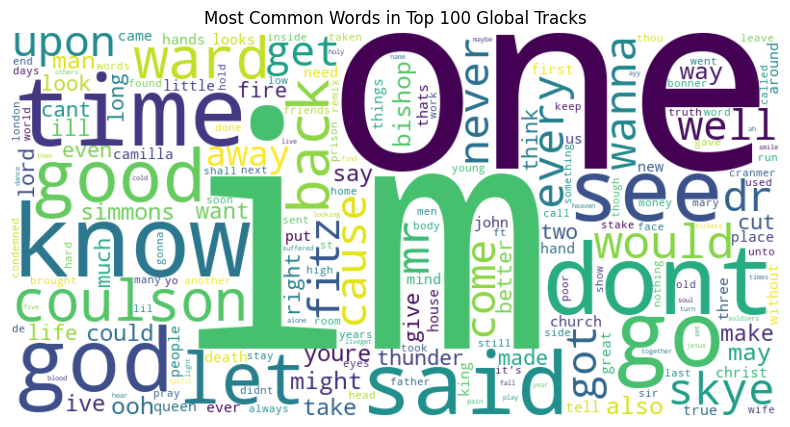

In [22]:
## Task 4: Data Visualization

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Top 100 Global Tracks')
plt.show()

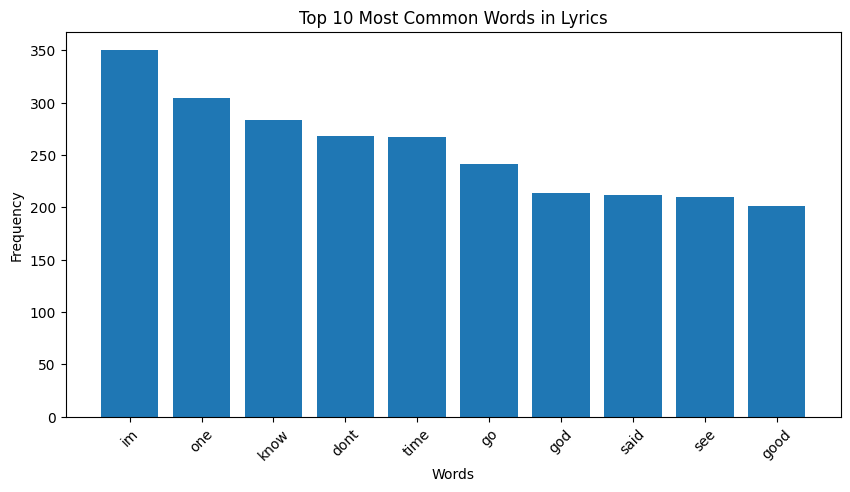

In [23]:
# Top 10 Most Common Words
top_10_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:10]
words, frequencies = zip(*top_10_words)

plt.figure(figsize=(10, 5))
plt.bar(words, frequencies)
plt.title('Top 10 Most Common Words in Lyrics')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [24]:
## Task 3: Analyze Lyrics

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def analyze_lyrics(df):
    all_lyrics = ' '.join(df['lyrics'])
    words = all_lyrics.split()
    word_freq = {}
    
    for word in words:
        if word.lower() not in stop_words:
            word_freq[word] = word_freq.get(word, 0) + 1
    
    return word_freq

word_frequencies = analyze_lyrics(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maylineamegan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


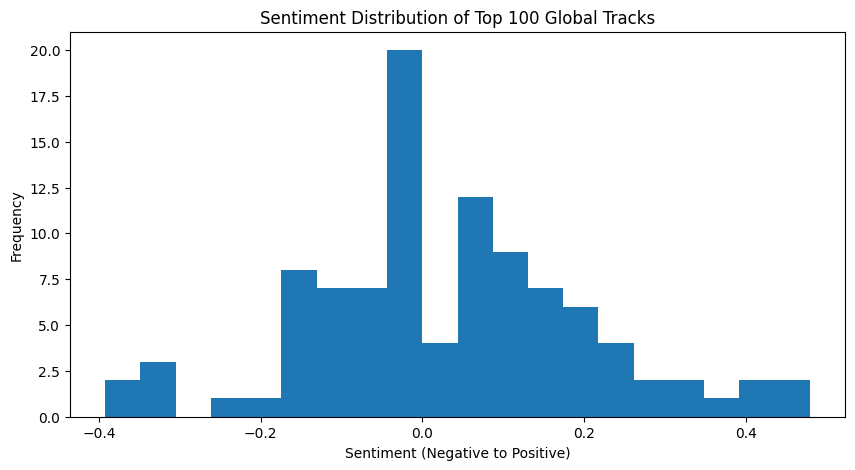

In [25]:
# Sentiment Distribution
plt.figure(figsize=(10, 5))
plt.hist(df['sentiment'], bins=20)
plt.title('Sentiment Distribution of Top 100 Global Tracks')
plt.xlabel('Sentiment (Negative to Positive)')
plt.ylabel('Frequency')
plt.show()

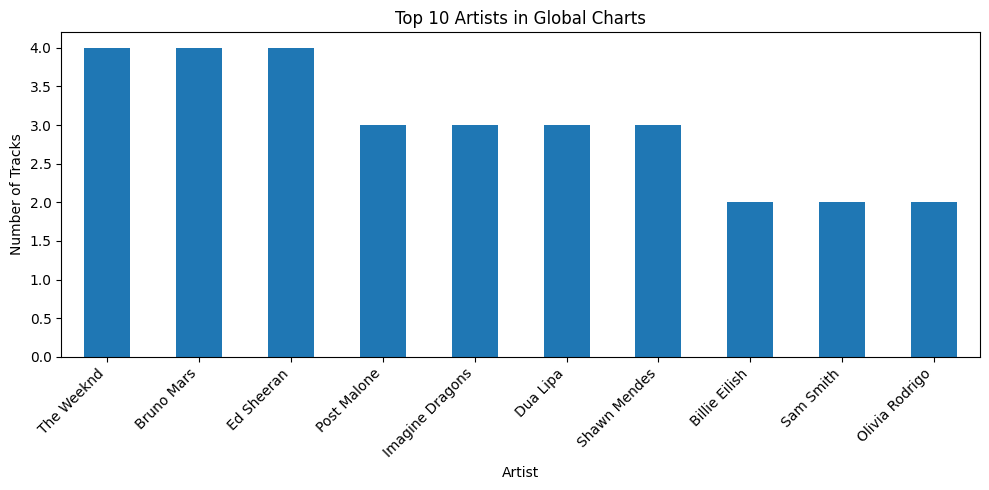

In [26]:
# Top 10 Artists
artist_track_count = df['artist'].value_counts().head(10)
plt.figure(figsize=(10, 5))
artist_track_count.plot(kind='bar')
plt.title('Top 10 Artists in Global Charts')
plt.xlabel('Artist')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

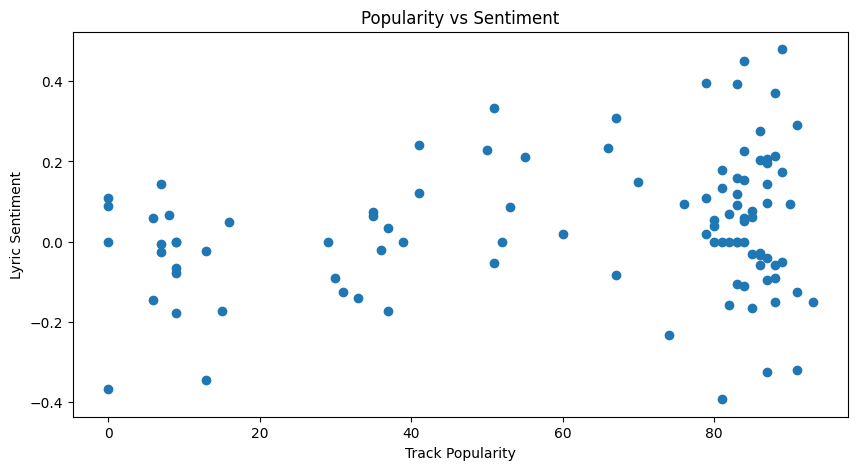

Correlation between track popularity and lyric sentiment: 0.22


In [28]:
# Popularity vs Sentiment
plt.figure(figsize=(10, 5))
plt.scatter(df['popularity'], df['sentiment'])
plt.title('Popularity vs Sentiment')
plt.xlabel('Track Popularity')
plt.ylabel('Lyric Sentiment')
plt.show()

correlation = df['popularity'].corr(df['sentiment'])
print(f"Correlation between track popularity and lyric sentiment: {correlation:.2f}")

In [29]:
correlation = df['popularity'].corr(df['sentiment'])
print(f"Correlation between track popularity and lyric sentiment: {correlation:.2f}")


Correlation between track popularity and lyric sentiment: 0.22


In [30]:
# Display the first few rows of the dataframe
print(df.head())

# Display basic information about the dataframe
print(df.info())

# Display summary statistics of the dataframe
print(df.describe())

          artist                                          track  popularity  \
0     The Weeknd                                Blinding Lights          89   
1     Ed Sheeran                                   Shape of You          85   
2  Lewis Capaldi                              Someone You Loved          88   
3   Harry Styles                                      As It Was          91   
4    Post Malone  Sunflower - Spider-Man: Into the Spider-Verse          81   

                                              lyrics  \
0  235 ContributorsTranslationsTürkçeSvenskaEspañ...   
1  354 ContributorsTranslationsTürkçeEspañolPortu...   
2  223 ContributorsTranslationsSvenskaEspañolPort...   
3  212 ContributorsTranslationsTürkçeEspañolPortu...   
4  2 ContributorsPost Malone Essentials Lyrics1. ...   

                                    processed_lyrics  sentiment  
0  235 contributorstranslationstürkçesvenskaespañ...  -0.050000  
1  354 contributorstranslationstürkçeespañolportu...   0

In [31]:
def print_analysis_summary(df, word_frequencies, correlation):
    print("## Spotify Playlist Analysis Summary")
    print("\nThis analysis provides insights into the selected Spotify playlist, focusing on various aspects such as artist representation, lyrical content, and sentiment analysis.")
    
    print(f"\nTotal tracks analyzed: {len(df)}")
    
    print("\n### Top 5 Artists by Track Count")
    top_artists = df['artist'].value_counts().head()
    for artist, count in top_artists.items():
        print(f"- {artist}: {count} tracks")
    print("These artists have made significant contributions to the playlist, showcasing their popularity and influence in the music scene.")

    print("\n### Top 5 Most Common Words in Lyrics")
    top_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, frequency in top_words:
        print(f"- {word}: {frequency} occurrences")
    print("The most frequently used words in the lyrics reflect common themes and emotions that resonate throughout the playlist.")

    print("\n### Sentiment Analysis")
    avg_sentiment = df['sentiment'].mean()
    print(f"- Average sentiment score: {avg_sentiment:.2f}")
    positive_tracks = (df['sentiment'] > 0).sum()
    negative_tracks = (df['sentiment'] < 0).sum()
    print(f"- Positive tracks: {positive_tracks}")
    print(f"- Negative tracks: {negative_tracks}")
    print("This analysis indicates the overall emotional tone of the lyrics, with a higher average sentiment suggesting a more positive listening experience.")

    print(f"\n### Correlation Between Track Popularity and Lyric Sentiment")
    print(f"The correlation coefficient between track popularity and lyric sentiment is {correlation:.2f}.")
    print("A positive correlation would suggest that more popular tracks tend to have more positive lyrics, while a negative correlation would indicate the opposite.")

    print("\n### Most Popular Track")
    most_popular = df.loc[df['popularity'].idxmax()]
    print(f"- {most_popular['track']} by {most_popular['artist']} (Popularity: {most_popular['popularity']})")
    print("This track stands out in the playlist, capturing the attention of listeners and reflecting current musical trends.")

    print("\n### Least Popular Track")
    least_popular = df.loc[df['popularity'].idxmin()]
    print(f"- {least_popular['track']} by {least_popular['artist']} (Popularity: {least_popular['popularity']})")
    print("Despite being the least popular, this track may still hold artistic value and appeal to niche audiences.")

# Call the summary function
print_analysis_summary(df, word_frequencies, correlation)

## Spotify Playlist Analysis Summary

This analysis provides insights into the selected Spotify playlist, focusing on various aspects such as artist representation, lyrical content, and sentiment analysis.

Total tracks analyzed: 100

### Top 5 Artists by Track Count
- The Weeknd: 4 tracks
- Bruno Mars: 4 tracks
- Ed Sheeran: 4 tracks
- Post Malone: 3 tracks
- Imagine Dragons: 3 tracks
These artists have made significant contributions to the playlist, showcasing their popularity and influence in the music scene.

### Top 5 Most Common Words in Lyrics
- -: 1409 occurrences
- I'm: 333 occurrences
- like: 251 occurrences
- know: 228 occurrences
- one: 216 occurrences
The most frequently used words in the lyrics reflect common themes and emotions that resonate throughout the playlist.

### Sentiment Analysis
- Average sentiment score: 0.03
- Positive tracks: 51
- Negative tracks: 38
This analysis indicates the overall emotional tone of the lyrics, with a higher average sentiment suggesting